In [2]:
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
from sklearn.preprocessing import normalize
X_valid, X_train = (X_train[:5000]/255), (X_train[5000:])/255
y_valid, y_train = y_train[:5000], y_train[5000:]


In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
              'Sneaker', 'Bag', 'Ankle boot']

In [8]:
class_names[y_train[3]]

'Ankle boot'

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow import keras

model  = Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy",
            optimizer="sgd",
            metrics=["accuracy"])


In [10]:
history = model.fit(X_train,y_train,epochs=12,validation_data=(X_valid,y_valid))

Epoch 1/12
1719/1719 [==============================] - 8s 3ms/step - loss: 0.7200 - accuracy: 0.7639 - val_loss: 0.4987 - val_accuracy: 0.8352
Epoch 2/12
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4916 - accuracy: 0.8283 - val_loss: 0.4843 - val_accuracy: 0.8330
Epoch 3/12
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4472 - accuracy: 0.8440 - val_loss: 0.4085 - val_accuracy: 0.8602
Epoch 4/12
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4194 - accuracy: 0.8531 - val_loss: 0.4013 - val_accuracy: 0.8640
Epoch 5/12
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4003 - accuracy: 0.8604 - val_loss: 0.3805 - val_accuracy: 0.8678
Epoch 6/12
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3840 - accuracy: 0.8664 - val_loss: 0.3907 - val_accuracy: 0.8670
Epoch 7/12
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3703 - accuracy: 0.8703 - val_loss: 0.3776 - val_accuracy:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [12]:
weights,biases = model.layers[1].get_weights()
weights.shape

(784, 300)

(0.0, 1.0)

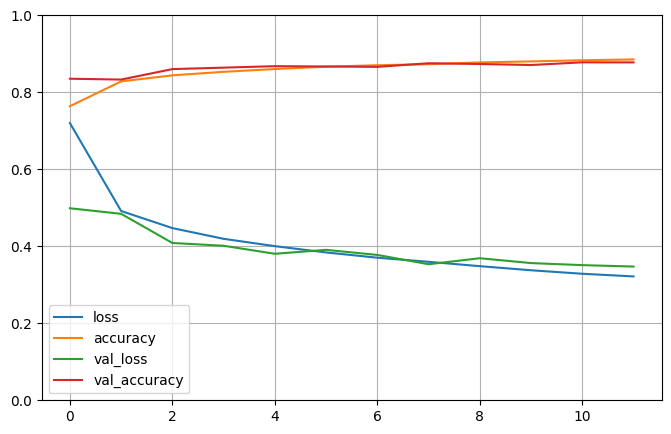

In [13]:
import matplotlib.pyplot as plt 
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

In [14]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 67.4741 - accuracy: 0.8296


[67.47405242919922, 0.8295999765396118]

313/313 [==============================] - 0s 1ms/step


<Axes: >

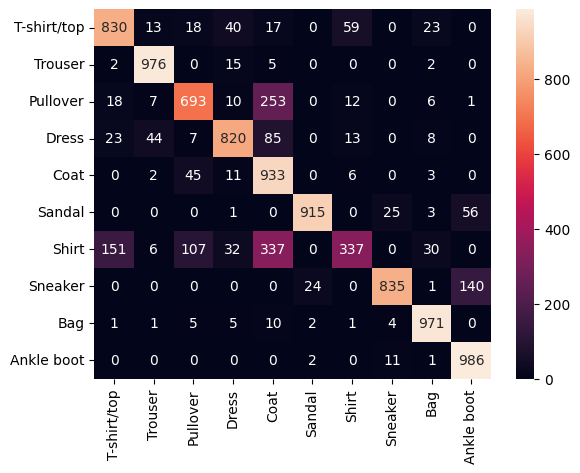

In [15]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)


Fine Tuning the model


In [16]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [17]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [18]:
import tensorflow
stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [19]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 35s]
val_accuracy: 0.8553636074066162

Best val_accuracy So Far: 0.8883636593818665
Total elapsed time: 00h 08m 29s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.001.



In [21]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=40, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/40
1375/1375 [==============================] - 5s 3ms/step - loss: 0.5056 - accuracy: 0.8229 - val_loss: 0.4530 - val_accuracy: 0.8310
Epoch 2/40
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3766 - accuracy: 0.8628 - val_loss: 0.3637 - val_accuracy: 0.8650
Epoch 3/40
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3351 - accuracy: 0.8767 - val_loss: 0.3723 - val_accuracy: 0.8652
Epoch 4/40
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3100 - accuracy: 0.8844 - val_loss: 0.3475 - val_accuracy: 0.8758
Epoch 5/40
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2898 - accuracy: 0.8917 - val_loss: 0.3465 - val_accuracy: 0.8758
Epoch 6/40
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2725 - accuracy: 0.8983 - val_loss: 0.3348 - val_accuracy: 0.8838
Epoch 7/40
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2612 - accuracy: 0.9027 - val_loss: 0.3571 - val_accuracy: